In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df1 = pd.read_csv('room+occupancy+estimation\Occupancy_Estimation.csv')

In [4]:
df1.head(2)

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1


Data cleaning

In [5]:
df2 = df1.drop(['Date','Time'],axis=1)

In [6]:
X = df2.iloc[:,0:-1]
y = df2['Room_Occupancy_Count']

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

In [8]:
ss = StandardScaler()
ss.fit_transform(X)

array([[-1.46303347, -1.35777517, -1.16233429, ...,  0.66446859,
        -0.31474885, -0.29402867],
       [-1.46303347, -1.35777517, -1.16233429, ...,  0.558817  ,
        -0.31474885, -0.29402867],
       [-1.29225542, -1.35777517, -1.30276354, ...,  0.4498638 ,
        -0.31474885, -0.29402867],
       ...,
       [-0.92223631, -0.82903247, -0.85807092, ...,  0.00414617,
        -0.31474885, -0.29402867],
       [-0.92223631, -0.82903247, -0.85807092, ...,  0.00414617,
        -0.31474885, -0.29402867],
       [-0.92223631, -0.82903247, -0.85807092, ...,  0.00414617,
        -0.31474885, -0.29402867]])

In [9]:
samples = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    samples.append((X_train, X_test, y_train, y_test))

In [10]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
result = pd.DataFrame(columns=['Sample', 'Best Accuracy', 'Best Kernel', 'Best Nu', 'Best Epsilon'])

In [11]:
def fitnessFunction(kernel, C, gamma):
  svm = SVC(kernel=kernel, C=C, gamma=gamma, max_iter=1000)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_test)
  return accuracy_score(y_pred, y_test)

In [12]:
for i in range(len(samples)):
  best_accuracy = 0
  best_C = 0
  best_gamma = 0
  for kernel in kernels:
    X_train, X_test, y_train, y_test = samples[i]
    C = np.random.uniform(0, 10)
    gamma = np.random.uniform(0, 10)
    score = fitnessFunction(kernel, C, gamma)
    if score>best_accuracy:
      best_accuracy = round(score, 2)
      best_C = round(C, 2)
      best_gamma = round(gamma, 2)
      best_kernel = kernel
  print('Best Accuracy = ', best_accuracy, 'Best Kernel = ', best_kernel, 'Best Nu = ', best_C, 'Best Epsilon = ', best_gamma)
  result.loc[i] = [i+1, best_accuracy, best_kernel, best_C, best_gamma]

Best Accuracy =  0.83 Best Kernel =  rbf Best Nu =  6.29 Best Epsilon =  9.41
Best Accuracy =  0.95 Best Kernel =  linear Best Nu =  6.39 Best Epsilon =  3.62
Best Accuracy =  0.97 Best Kernel =  linear Best Nu =  8.98 Best Epsilon =  6.74
Best Accuracy =  0.92 Best Kernel =  linear Best Nu =  9.77 Best Epsilon =  0.7
Best Accuracy =  0.95 Best Kernel =  poly Best Nu =  4.05 Best Epsilon =  6.77
Best Accuracy =  0.84 Best Kernel =  poly Best Nu =  8.46 Best Epsilon =  2.65
Best Accuracy =  0.95 Best Kernel =  rbf Best Nu =  3.26 Best Epsilon =  0.25
Best Accuracy =  0.96 Best Kernel =  poly Best Nu =  2.7 Best Epsilon =  0.57
Best Accuracy =  0.97 Best Kernel =  poly Best Nu =  3.0 Best Epsilon =  3.39
Best Accuracy =  0.89 Best Kernel =  linear Best Nu =  8.37 Best Epsilon =  9.05


In [13]:
result

,Sample,Best Accuracy,Best Kernel,Best Nu,Best Epsilon
0,1,0.83,rbf,6.29,9.41
1,2,0.95,linear,6.39,3.62
2,3,0.97,linear,8.98,6.74
3,4,0.92,linear,9.77,0.70
4,5,0.95,poly,4.05,6.77
5,6,0.84,poly,8.46,2.65
6,7,0.95,rbf,3.26,0.25
7,8,0.96,poly,2.70,0.57
8,9,0.97,poly,3.00,3.39
9,10,0.89,linear,8.37,9.05


In [14]:
X_train, X_test, y_train, y_test = samples[result['Best Accuracy'].idxmax()]

In [15]:
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel=result['Best Kernel'].iloc[result['Best Accuracy'].idxmax()],
                                                        C=result['Best Nu'].iloc[result['Best Accuracy'].idxmax()],
                                                        gamma=result['Best Epsilon'].iloc[result['Best Accuracy'].idxmax()],
                                                        max_iter = 1000), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1,
                                                        train_sizes = np.linspace(0.01, 1.0, 50))

In [16]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

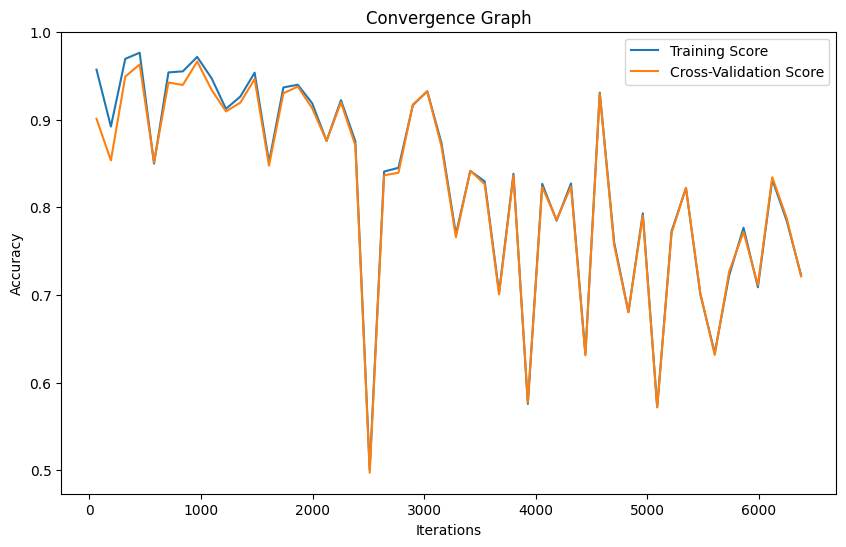

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Convergence Graph')
plt.legend(loc="best")
plt.show()